# 7. Natural Language Processing

Wordle polega na odgadnięciu 5-literowego słowa na podstawie wskazówek o występujących literach:

https://wordlegame.org/

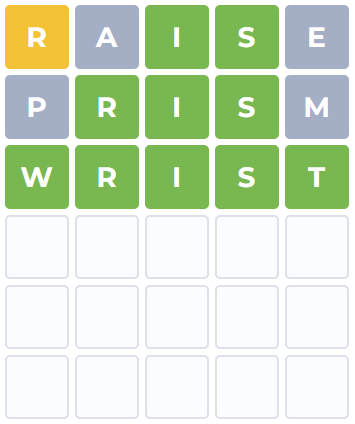

Lista słów które mogą być rozwiązaniem ma 2309 pozycji i jest dostępna [tutaj](https://drive.google.com/file/d/1I0i3X2s28c9iYULJvq9GWDlQVo_oPSe4/view?usp=sharing).

Lista słów akceptowanych jest większa [tutaj](https://drive.google.com/file/d/1R78GyUcub6yeD4qmFoXmkRK3KBU98EEN/view?usp=sharing), ale z uwagi na ograniczony czas można pozostać przy podstawowej puli.


## Zadanie: 
1. Znajdź optymalne słowo rozpoczynające rozgrywkę. 

2. Zaimplementuj algorytm wygrywający Wordle w jak najniższej liczbie prób trafień (docelowo średnio mniej niż 4).

Można korzystać z dowolnej własnej strategii i dowolnie wybranej techniki.

Optymalne rozwiazania:

1. Zliczanie liter - trafienie dobrych pozycji (zielone pola)

 - `slate` 
 - `crane`

1. Trafienie jak najwiecej liter (zolte pola)

  - `alert`
  - `later`
  - `alter`

1. Drzewo decyzyjne
  - `raise`


Najgorsze slowo: `fuzzy`

In [ ]:
import numpy as np
import pandas as pd
import random
from collections import Counter, OrderedDict
import string

LETTERS = list(string.ascii_lowercase)
print(len(LETTERS))

try:
    WORDS = pd.read_csv('word_pull_machine.txt', sep="\n", header=None)[0].to_list()
    print(len(WORDS))
except Exception as e:
    print(e)


26
2309


In [ ]:
from typing import List

class Wordle:

    def __init__(
        self, 
        word_list: List, 
        rounds: int = 6, 
        number_of_best_options_to_print: int = 0, 
        verbose: bool = False
    ):
        self.word_list = word_list.copy()
        self.MAX_NUMBER_OF_ROUNDS = rounds
        self.answer = None 
        self.possible_words = self.word_list.copy()
        self.possible_letters = list(string.ascii_lowercase)
        self.PRINT_TOP_OPTIONS = number_of_best_options_to_print
        self.won = False
        self.verbose = verbose


    def get_frequencies(self):
        counter_dict = dict(
            zip(self.possible_letters, [0 for _ in range(len(self.possible_letters))])
        )
        for word in self.possible_words:
            c = Counter(word)
            for letter, count in c.items():
                counter_dict[letter] += count
        # print( sorted(counter_dict.items(), key = lambda kv: kv[1], reverse = True) )
        return counter_dict


    def guess_word(self):
        counter_dict = self.get_frequencies()
        words_costs = dict(
            zip(self.possible_words, [0 for _ in range(len(self.possible_words))])
        )
        for word in self.possible_words:
            for letter in set(word):
                words_costs[word] += counter_dict[letter]
        del counter_dict
        words_costs = sorted(words_costs.items(), key = lambda kv: kv[1], reverse = True)
        if self.verbose and self.PRINT_TOP_OPTIONS:
            print(f"{self.PRINT_TOP_OPTIONS} best options:  {words_costs[:self.PRINT_TOP_OPTIONS]} ")
    
        #if there is more than 1 word with same cost, make random choice
        best_word_cost = words_costs[0][1]
        best_words = [words_costs[0][0], ]
        for wc in words_costs:
            if wc[1] == best_word_cost:
                best_words.append(wc[0])
        del words_costs
        return random.choice(best_words)



    def evaluate_word(self, guessed_word: str):

        #we reject letters in guessed word that are not in the answer
        letters_to_drop = []
        for letter in guessed_word:
            if letter not in self.answer:
                letters_to_drop.append(letter)
                
        map(self.possible_letters.pop, letters_to_drop)
        possible_words = []

        for word in self.possible_words:
            should_add = True
            for letter in letters_to_drop:
                if letter in word:
                    should_add = False
            if should_add:
                possible_words.append(word)
        self.possible_words = possible_words
        #dodac obsluge pozycji

        guessed_positions = []
        for i, letter in enumerate(zip(self.answer, guessed_word)):
            if letter[0] == letter[1]:
                guessed_positions.append((i, letter[0]))

        # print(guessed_positions)
        
        if guessed_positions:
            possible_words = []
            for word in self.possible_words:
                should_add = [False for _ in range(len(guessed_positions))] 
                i = 0
                for pos, letter in guessed_positions:
                    if word[pos] == letter:
                        should_add[i] = True
                    i += 1
                if all(should_add):
                    possible_words.append(word)

            self.possible_words = possible_words


      
    def play(self, answer: str = "") -> int:
        if len(answer) == 5:
            self.answer = answer
        else:
            self.answer = random.choice(self.word_list)

        self.possible_words = self.word_list.copy()
        self.possible_letters = list(string.ascii_lowercase)
        self.won = False
        if self.verbose:
            print(30*'=')
            print(f"The answer is {self.answer}")
            print(30*'=')

        for round in range(self.MAX_NUMBER_OF_ROUNDS):
            if self.verbose:
                print(f"len of possible_words: {len(self.possible_words)}")
            guessed_word = self.guess_word()
            if self.verbose:
                print(30*'-')
                print(f"The guess is: {guessed_word}")
                print(30*'-')

            if guessed_word == self.answer:
                self.won = True
                if self.verbose:
                    print(f"You won in {round+1} rounds")
                break

            #reject guessed word
            for i, word in enumerate(self.possible_words):
                if word == guessed_word:
                    del self.possible_words[i]
            self.evaluate_word(guessed_word)
        
        if not self.won:
            if self.verbose:
                print(f"Game over. MAX_NUMBER_OF_ROUNDS = {self.MAX_NUMBER_OF_ROUNDS} exceeded")
            return 0, self.answer
        else:
            return round+1, self.answer

### Rozgrywka z losowym słowem

In [ ]:
game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 3, verbose = True)
game.play()

The answer is shaft
len of possible_words: 2309
3 best options:  [('alert', 4547), ('alter', 4547), ('later', 4547)] 
------------------------------
The guess is: alert
------------------------------
len of possible_words: 79
3 best options:  [('saint', 228), ('hoist', 219), ('snout', 215)] 
------------------------------
The guess is: saint
------------------------------
len of possible_words: 7
3 best options:  [('shout', 29), ('scout', 27), ('spout', 27)] 
------------------------------
The guess is: shout
------------------------------
len of possible_words: 1
3 best options:  [('shaft', 5)] 
------------------------------
The guess is: shaft
------------------------------
You won in 4 rounds


(4, 'shaft')

### Rozgrywka dla słowa `haste`

In [ ]:
WORD = "haste"
GAMES = 1000

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 3, verbose = True)
game.play(WORD)

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 0)
_sum = 0
for _ in range(GAMES):
    _sum += game.play(WORD)[0]

print("\n\n")
print(f"Średnia liczba rund potrzebna do odgadnięcia słowa {WORD} wynosi {_sum/GAMES:.2f}")

The answer is haste
len of possible_words: 2309
3 best options:  [('alert', 4547), ('alter', 4547), ('later', 4547)] 
------------------------------
The guess is: later
------------------------------
len of possible_words: 146
3 best options:  [('nasty', 377), ('tangy', 363), ('matey', 359)] 
------------------------------
The guess is: nasty
------------------------------
len of possible_words: 7
3 best options:  [('paste', 31), ('baste', 30), ('caste', 30)] 
------------------------------
The guess is: paste
------------------------------
len of possible_words: 5
3 best options:  [('baste', 22), ('caste', 22), ('haste', 22)] 
------------------------------
The guess is: caste
------------------------------
len of possible_words: 4
3 best options:  [('baste', 18), ('haste', 18), ('waste', 18)] 
------------------------------
The guess is: baste
------------------------------
len of possible_words: 3
3 best options:  [('haste', 14), ('waste', 14), ('taste', 13)] 
----------------------

### Rozgrywka dla słowa `fuzzy`

In [ ]:
WORD = "fuzzy"
GAMES = 1000

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 3, verbose = True)
game.play(WORD)

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 0)
_sum = 0
for _ in range(GAMES):
    _sum += game.play(WORD)[0]

print("\n\n")
print(f"Średnia liczba rund potrzebna do odgadnięcia słowa {WORD} wynosi {_sum/GAMES:.2f}")

The answer is fuzzy
len of possible_words: 2309
3 best options:  [('alert', 4547), ('alter', 4547), ('later', 4547)] 
------------------------------
The guess is: later
------------------------------
len of possible_words: 196
3 best options:  [('noisy', 454), ('scion', 429), ('sonic', 429)] 
------------------------------
The guess is: noisy
------------------------------
len of possible_words: 16
3 best options:  [('dumpy', 62), ('pudgy', 56), ('jumpy', 55)] 
------------------------------
The guess is: dumpy
------------------------------
len of possible_words: 2
3 best options:  [('buggy', 7), ('fuzzy', 7)] 
------------------------------
The guess is: fuzzy
------------------------------
You won in 4 rounds



Średnia liczba rund potrzebna do odgadnięcia słowa fuzzy wynosi 4.70


### Słowo zawierające powtarzające się litery

In [ ]:
WORD = "eerie"
GAMES = 1000

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 3, verbose = True)
game.play(WORD)

game = Wordle(word_list = WORDS, rounds = 10, number_of_best_options_to_print = 0)
_sum = 0
for _ in range(GAMES):
    _sum += game.play(WORD)[0]

print("\n\n")
print(f"Średnia liczba rund potrzebna do odgadnięcia słowa {WORD} wynosi {_sum/GAMES:.2f}")

The answer is eerie
len of possible_words: 2309
3 best options:  [('alert', 4547), ('alter', 4547), ('later', 4547)] 
------------------------------
The guess is: later
------------------------------
len of possible_words: 695
3 best options:  [('snore', 1614), ('rouse', 1567), ('crone', 1563)] 
------------------------------
The guess is: snore
------------------------------
len of possible_words: 46
3 best options:  [('dirge', 146), ('ridge', 146), ('pride', 144)] 
------------------------------
The guess is: dirge
------------------------------
len of possible_words: 4
3 best options:  [('curve', 18), ('puree', 15), ('verve', 15)] 
------------------------------
The guess is: curve
------------------------------
len of possible_words: 1
3 best options:  [('eerie', 5)] 
------------------------------
The guess is: eerie
------------------------------
You won in 5 rounds



Średnia liczba rund potrzebna do odgadnięcia słowa eerie wynosi 5.58


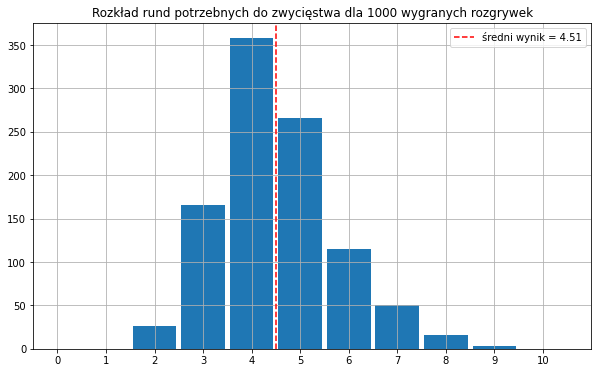

In [ ]:
max_rounds = 10
games = 1000

game = Wordle(word_list = WORDS, rounds = max_rounds, number_of_best_options_to_print = 0)

scores = dict(
    zip(list(range(max_rounds+1)), [0 for _ in range(max_rounds+1)])
)

bad = []
for _ in range(games):
    i, answer = game.play()
    scores[i] += 1
    if i == 0:
        bad.append(answer)

won_games = games - scores[0]
mean_score = 0.0
for k, v in scores.items():
    mean_score += k*v
mean_score /= won_games

indexes = np.arange(len(scores.keys()))
import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 6))
plt.bar(indexes, scores.values(), width = 0.9)
plt.xticks(indexes, scores.keys())
plt.grid()
plt.title(f"Rozkład rund potrzebnych do zwycięstwa dla {won_games} wygranych rozgrywek")
plt.axvline(mean_score, color='red', linestyle='--', label=f"średni wynik = {mean_score:.2f}")
plt.legend()
plt.gca().set_xlim(left = -0.5)
plt.show()

0 na wykresie oznacza przegranie gry, tj. przekroczenie maksymalnej liczby zgadnięć

Słowa, których nie udało się odgadnąć w ciągu maksymalnej liczby rund:

In [ ]:
set(bad)

set()